## This notebook is used to prepare the three figures in the manuscript.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
from pathlib import Path

from cartopy.feature import LAND as cLAND

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from bopak import set_BOEASE2,  bodata3d, bodb
from bopak.reprocess.utils import loc_ease2
from utils import ptval, pFDR

In [4]:
import matplotlib
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('font',**{'family':'serif','variant':'small-caps'})
ftsz = 16
lw = 2

In [5]:
picdir = Path('/home/zliu/Outpics/BO/20250225/')
picroot = Path('/home/zliu/Outpics/BO/20250529/')
picroot = Path('/home/zliu/Outpics/BO/20250612/')
picroot = Path('/home/zliu/Outpics/BO/20251021/')
picfmt = 'png'
picdpi = 300
if not picroot.exists(): picroot.mkdir(parents=True,exist_ok=True)

In [6]:
mds,boprj = set_BOEASE2()
pcproj = ccrs.PlateCarree()
XLIM = mds.XLIM
YLIM = mds.YLIM
xx,yy = np.meshgrid(mds.X.values, mds.Y.values)

In [7]:
BOROOT = Path('/data/BO/EASE2/combined/kappa_alb_snow3_y058_part_albV006/nc')
datdb = bodb(BOROOT,ftype='nc',freq='Y')
gridfn = '/data/BO/EASE2/regridded_G02202-cdr-ancillary-nh.nc'
with xr.open_dataset(gridfn) as dsgrid:
    dsgrid.load()

In [8]:
outdir = BOROOT.parent.parent/'yearly/kappa_alb_snow3_y058_refl_albV006'
ofn = outdir/'BO_yearly.nc'
with xr.open_dataset(ofn) as dsyearly:
    dsyearly.load()

In [14]:
dsyearly

<xarray.Dataset> Size: 232MB
Dimensions:                          (time: 38, Y: 263, X: 263)
Coordinates:
    lat                              (Y, X) float64 553kB 47.5 47.67 ... 47.5
    lon                              (Y, X) float64 553kB -45.0 -44.78 ... 135.0
  * X                                (X) float64 2kB -3.275e+06 ... 3.275e+06
  * Y                                (Y) float64 2kB -3.275e+06 ... 3.275e+06
  * time                             (time) int64 304B 1984 1985 ... 2020 2021
Data variables: (12/22)
    sic                              (time, Y, X) float32 11MB 0.0002066 ... nan
    sith                             (time, Y, X) float32 11MB 0.0 0.0 ... nan
    sith_norm                        (time, Y, X) float32 11MB 0.0 nan ... nan
    alb_AGE                          (time, Y, X) float32 11MB nan nan ... nan
    insol                            (time, Y, X) float32 11MB 120.2 ... nan
    fmelt                            (time, Y, X) float32 11MB nan nan ... nan
    ...                               ...
    accu_habs_ice_dep_AGE_KAPPA0     (time, Y, X) float32 11MB 0.0 0.0 ... nan
    accu_hall_ice_SIC                (time, Y, X) float32 11MB 1.334 0.0 ... nan
    accu_h_ocn_SIC                   (time, Y, X) float32 11MB 3.533e+03 ... nan
    accu_habs_ocn_SIC                (time, Y, X) float32 11MB 3.533e+03 ... nan
    accu_hrfl_ocn_SIC                (time, Y, X) float32 11MB 266.0 ... nan
    accu_insol                       (time, Y, X) float32 11MB 3.801e+03 ... nan
Attributes:
    OCN_ALB:     0.07
    KAPPA_DEFT:  1
    KAPPA_SNOW:  3
    KAPPA_POND:  0.7

In [9]:
vns = [vn for vn in dsyearly.data_vars if vn not in ['lat','lon','sic','sith'] ]
for vn in vns:
    dsyearly[vn] = dsyearly[vn].where(dsyearly[vn]>0)

dsyearly['hrefl'] = dsyearly['accu_hrfl_ocn_SIC']+dsyearly['accu_hrfl_ice_AGE']
dsyearly['habs'] = dsyearly['accu_habs_ice_top_AGE']+dsyearly['accu_habs_ice_dep_AGE_KAPPA_ALB']
dsyearly['htran'] = dsyearly['accu_h_ocn_SIC'] + dsyearly['accu_hthr_ice_AGE_KAPPA_ALB']
dsyearly['htran_ice'] = dsyearly['accu_hthr_ice_AGE_KAPPA_ALB']
dsyearly['otran'] = dsyearly['accu_h_ocn_SIC']#/dsyearly['htran']
dsyearly['itran'] = dsyearly['accu_hthr_ice_AGE_KAPPA_ALB']#/dsyearly['htran']
dsyearly['rotran'] = dsyearly['accu_h_ocn_SIC']/dsyearly['htran']
dsyearly['ritran'] = dsyearly['accu_hthr_ice_AGE_KAPPA_ALB']/dsyearly['htran']
dsyearly['Transmittance'] = dsyearly['htran']/dsyearly['accu_insol']
dsyearly['Transmittance_ice'] = dsyearly['htran_ice']/dsyearly['accu_insol']
dsyearly['oTransmittance'] = dsyearly['otran']/dsyearly['accu_insol']
dsyearly['iTransmittance'] = dsyearly['itran']/dsyearly['accu_insol']
dsyearly['Albedo'] = dsyearly['hrefl']/dsyearly['accu_insol']
dsyearly['Absorptance'] = dsyearly['habs']/dsyearly['accu_insol']

dsmask = xr.Dataset()
for vn in dsyearly.data_vars:
    dsmask[vn] = dsyearly[vn].isnull().sum(dim='time')

In [10]:
dsfit1d = dsyearly.polyfit(dim='time',deg=1,cov=True)
dsfit1d = dsfit1d.assign_coords({'lat':dsyearly['lat'],'lon':dsyearly['lon']})
ndof = len(dsyearly.time)
from utils import ptval
ds_tval, ds_pval, dstrnd= ptval(dsfit1d,ndof)
ds_slope = dstrnd.sel(degree=1)

/home/zliu/micromamba/envs/arctic/lib/python3.11/site-packages/xarray/core/nputils.py:247: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/zliu/micromamba/envs/arctic/lib/python3.11/site-packages/xarray/core/nputils.py:247: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/zliu/micromamba/envs/arctic/lib/python3.11/site-packages/xarray/core/nputils.py:247: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/zliu/micromamba/envs/arctic/lib/python3.11/site-packages/xarray/core/nputils.py:247: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/zliu/micromamba/envs/arctic/lib/python3.11/site-packages/xarray/core/nputils.py:247: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/zliu/micromamba/envs/arctic/lib/python3.11/site-packages/xarray/core/nputils.py:247: Rank

In [25]:


def plot_trend(dat_in,dat_pval=None, FDR=True,mask=None,
               pthresh=0.05,hatches='..',
               lvl=None,cmap='RdBu_r',ttl='test', 
               vscale=1,add_cb=True,
               cb_ttl='',cb_scale = .82, cb_ntick=11,cb_ticks=None,add_cb_ttl=True,
               fig=None, ax=None,
               ):
    #cmap = 'turbo'
    if fig is None:
        fig, ax = plt.subplots(1,1, figsize=(6,5),subplot_kw=dict(projection=boprj))
    if lvl is not None:
        vmin = lvl.min()
        vmax = lvl.max()
    
    if mask is None: mask = True
    chdl = ax.contourf(xx,yy,dat_in.where(mask)*vscale,levels=lvl,cmap=cmap,extend='both')
    if add_cb:
        cb = fig.colorbar(chdl,ax=ax,shrink=cb_scale)
        if add_cb_ttl: cb.ax.set_title(cb_ttl,pad=20,loc='left')
        if cb_ticks is not None: cb.ax.set_yticks(cb_ticks)
    else:
        cb = None
    ax.set_title(ttl,fontsize=ftsz)
    if dat_pval is not None:
        dat_pval_plot = dat_pval
        if FDR: dat_pval_plot = pFDR(dat_pval)
        ax.contourf(xx,yy,dat_pval_plot.where(mask),levels=[0,pthresh],hatches=[hatches,None],colors='none')

    
    ax.coastlines(color='.3')
    ax.set_extent([-XLIM,XLIM,-YLIM,YLIM],crs=boprj)
    ax.add_feature(cLAND,color='.7',zorder=1)
    ax.gridlines(xlocs=np.arange(-180,180,45),color='.6')
    ax.set_facecolor('.9')
    return fig, ax, chdl, cb
    


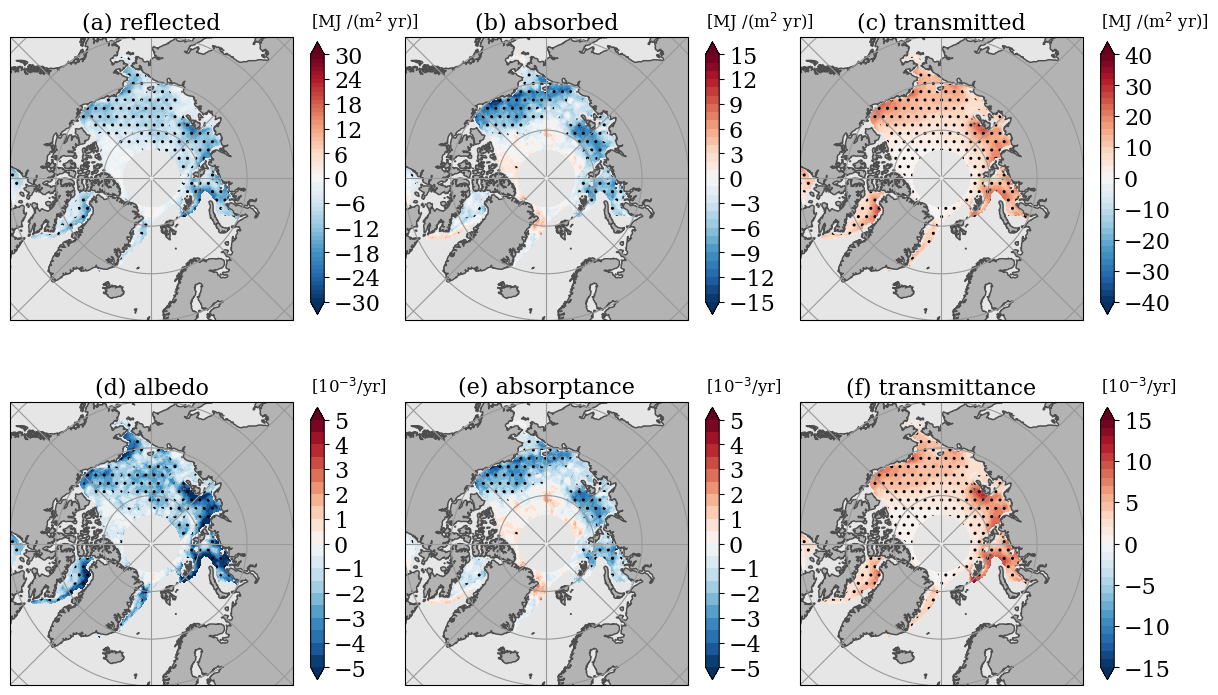

In [ ]:
yr00 = 1984
LATN = 84
LATS = 60
vrfl = 40 
vabs = 40 
vthr = 40
vrfl = 30 
vabs = 15 
vthr = 40
NYR_MISS = 10
FDR = True
FDR = 0.05
in_range = (dsyearly.lat>LATS)&(dsyearly.lat<LATN)
#dattrend = ds_slope1988.where(in_range)
#datpval = ds_pval1988.where(in_range)
#dattrend = ds_slope.where(in_range)
dattrend = ds_slope.where(in_range)
datpval = ds_pval.where(in_range)

MJm2yr = '[MJ /(m$^{2}$ yr)]'
#MJm2yr = '[MJ m$^{-2}$/yr]'

# MJm2yr = r'$\left[ \mathrm{\frac{MJ}{m^2\cdot year}}\right]$'
# MJm2yr = r'$[ \rm{\frac{MJ}{m^2\cdot year}}]$'
fig, axs = plt.subplots(2,3, figsize=(12,7.5),subplot_kw=dict(projection=boprj))

ax = axs[0][0]
vn = 'hrefl'
fig, ax, chdl, cb = plot_trend(dattrend[vn],datpval[vn],fig=fig, ax=ax,FDR=FDR,
                         mask = dsmask[vn]<NYR_MISS,
                     ttl=f'(a) reflected',cb_ttl=MJm2yr,
                     lvl=np.linspace(-vrfl,vrfl,61),cb_ticks=np.linspace(-vrfl,vrfl,11))
#cb.set_label(MJm2yr,loc='center',pad=13)
ax = axs[0][1]
vn = 'habs'
fig, ax, chdl, cb = plot_trend(dattrend[vn],datpval[vn],fig=fig, ax=ax,FDR=FDR,
                         mask = dsmask[vn]<NYR_MISS,
                     ttl=f'(b) absorbed',cb_ttl=MJm2yr,
                     lvl=np.linspace(-vabs,vabs,31),cb_ticks=np.linspace(-vabs,vabs,11))
ax = axs[0][2]
vn = 'htran'
fig, ax, chdl, cb = plot_trend(dattrend[vn],datpval[vn],fig=fig, ax=ax,FDR=FDR,
                         mask = dsmask[vn]<NYR_MISS,
                     ttl=f'(c) transmitted',cb_ttl=MJm2yr,
                     lvl=np.linspace(-vthr,vthr,41),cb_ticks=np.linspace(-vthr,vthr,9))


vrflr = 5
ax = axs[1][0]
vn = 'Albedo'
fig, ax, chdl, cb = plot_trend(dattrend[vn],datpval[vn],fig=fig, ax=ax,vscale=1000,FDR=FDR,
                         mask = dsmask[vn]<NYR_MISS,
                     ttl=f'(d) albedo',cb_ttl='[10$^{-3}$/yr]', add_cb_ttl=True,
                     lvl=np.linspace(-vrflr,vrflr,21),cb_ticks=np.linspace(-vrflr,vrflr,11))

ax = axs[1][1]
vn = 'Absorptance'
fig, ax, chdl, cb = plot_trend(dattrend[vn],datpval[vn],fig=fig, ax=ax,vscale=1000,FDR=FDR,
                         mask = dsmask[vn]<NYR_MISS,
                     ttl=f'(e) absorptance',cb_ttl='[10$^{-3}$/yr]',add_cb_ttl=True,
                     lvl=np.linspace(-vrflr,vrflr,21),cb_ticks=np.linspace(-vrflr,vrflr,11))

ax = axs[1][2]
vn = 'Transmittance'
fig, ax, chdl, cb = plot_trend(dattrend[vn],datpval[vn],fig=fig, ax=ax,vscale=1000,FDR=FDR,
                         mask = dsmask[vn]<NYR_MISS,
                     ttl=f'(f) transmittance',cb_ttl='[10$^{-3}$/yr]', add_cb_ttl=True,
                     lvl=np.linspace(-15,15,31),cb_ticks=np.linspace(-15,15,7))


fig.tight_layout()   
fig.subplots_adjust(hspace=.1,top=.95)
picfn = picroot/f'trend_solar_partition_pixel_{yr00}_FDR{FDR}.{picfmt}'
#fig.savefig(picfn,format=picfmt,dpi=picdpi,bbox_inches='tight')

In [13]:
def plot_year_4by3(tyr, ds_in, cmap='turbo',cb_scale=.8,vmin=0,vmax=2500,vmax_thr=500,vmax_rthr=.5,
                   LATS=60,
              ttls=None,fig=None, axs=None,panel_pre=['abcdef']):

    if fig is None: fig, axs = plt.subplots(2,3, figsize=(12,7.5),subplot_kw=dict(projection=boprj))
    ttls = ['reflectance','absorptance','transmittance',
            'reflected solar heat','heat absorbed by ice','heat transmitted',
            ]
    ttls = [f'({panel_pre[i]}) {ttls[i]}' for i in range(6)]
    for iax,ax in enumerate(axs):
        ax.coastlines(color='.3')
        ax.set_extent([-XLIM,XLIM,-YLIM,YLIM],crs=boprj)
        ax.add_feature(cLAND,color='.8')
        ax.gridlines(xlocs=np.arange(-180,180,45),color='.6')
        ax.set_facecolor('.98')
        ax.set_title(f'{ttls[iax]}',fontsize=ftsz-1)
    
    tds = ds_in.sel(time=tyr)
        
    valid_melt = (tds['fmelt']>80)&(tds['fmelt']<210)
    valid_freeze = (tds['ffreeze']>210)&(tds['ffreeze']<360)
    fm_mask = valid_melt&valid_freeze#&(alb_AGE>0)
    lat_range = tds.lat>LATS#&(ds.lat<LATN)

    

    habs = tds['habs'].where(fm_mask)
    hrfl = tds['hrefl'].where(fm_mask)
    htran = tds['htran'].where(fm_mask)
    insol = tds['accu_insol'].where(fm_mask)



    r_refl = tds['Albedo']
    r_abs = tds['Absorptance']
    r_trans = tds['Transmittance']

    chdls = []
    cb_scale = 1



    ax = axs[0]
    chdl = ax.contourf(xx,yy,r_refl.where(lat_range),levels=np.linspace(0,1,41),cmap=cmap,extend='both')
    chdls.append(chdl)
    cb = fig.colorbar(chdl,ax=ax,shrink=cb_scale)
    cb.ax.set_yticks(np.linspace(0,1,11))

    
    ax = axs[1]
    chdl = ax.contourf(xx,yy,r_abs.where(lat_range),levels=np.linspace(0,.5,41),cmap=cmap,extend='both')
    chdls.append(chdl)
    cb = fig.colorbar(chdl,ax=ax,shrink=cb_scale)
    cb.ax.set_yticks(np.linspace(0,.5,11))
    
    ax = axs[2]
    chdl = ax.contourf(xx,yy,r_trans.where(lat_range),levels=np.linspace(0,vmax_rthr,41),cmap=cmap,extend='both')
    chdls.append(chdl)
    cb = fig.colorbar(chdl,ax=ax,shrink=cb_scale)
    cb.ax.set_yticks(np.linspace(0,vmax_rthr,11))

    ax = axs[3]
    chdl = ax.contourf(xx,yy,hrfl.where(lat_range),levels=np.arange(0,2500+1,50),cmap=cmap,extend='both')
    chdls.append(chdl)
    cb = fig.colorbar(chdl,ax=ax,shrink=cb_scale)
    cb.ax.set_yticks(np.arange(0,2500+1,250))
    cb.ax.set_title(f'[MJ/m$^2$]', pad=5, fontsize=ftsz-4, loc='left')

    ax = axs[4]
    chdl = ax.contourf(xx,yy,habs.where(lat_range),levels=np.arange(0,1500+1,30),cmap=cmap,extend='both')
    chdls.append(chdl)
    cb = fig.colorbar(chdl,ax=ax,shrink=cb_scale)
    cb.ax.set_yticks(np.arange(0,1500+1,150))
    cb.ax.set_title(f'[MJ/m$^2$]', pad=5, fontsize=ftsz-4, loc='left')

    ax = axs[5]
    chdl = ax.contourf(xx,yy,htran.where(lat_range),levels=np.arange(0,vmax_thr+1,10),cmap=cmap,extend='both')
    chdls.append(chdl)
    cb = fig.colorbar(chdl,ax=ax,shrink=cb_scale)
    cb.ax.set_yticks(np.arange(0,vmax_thr+1,150))
    cb.ax.set_title(f'[MJ/m$^2$]', pad=5, fontsize=ftsz-4, loc='left')



    # for ax in [axs[0],axs[3]]:
    #     ax.set_ylabel(f'{tyr}',fontsize=ftsz)
    #     ax.text(-0.05, 0.5, f'{tyr}', va='center', ha='right',
    #         rotation=90, fontsize=ftsz, transform=ax.transAxes)


    return fig, axs, chdls



def plot_Figure1(yrs, ds_in,cmap='turbo',cb_scale=.8,plot_contourf=True,vmin=0,vmax=2500,vmax1=2500,vmax_thr=1000,vmax_rthr=.5,
                 LATS=60, 
                 c3r4=True, figsize=(12,12),
                 ttls=None,):

    if c3r4:
        fig, axs = plt.subplots(4,3, figsize=figsize,subplot_kw=dict(projection=boprj))
        fig, axs1,chdls1 = plot_year_4by3(yrs[0],ds_in,fig=fig, axs=np.append(axs[0],axs[2]),cmap=cmap,vmax_thr=vmax_thr,vmax_rthr=vmax_rthr,panel_pre='abcghi')
        fig, axs2,chdls2 = plot_year_4by3(yrs[1],ds_in,fig=fig, axs=np.append(axs[1],axs[3]),cmap=cmap,vmax_thr=vmax_thr,vmax_rthr=vmax_rthr,panel_pre='defjkl')

    

    
    return fig, axs, chdls1+chdls2

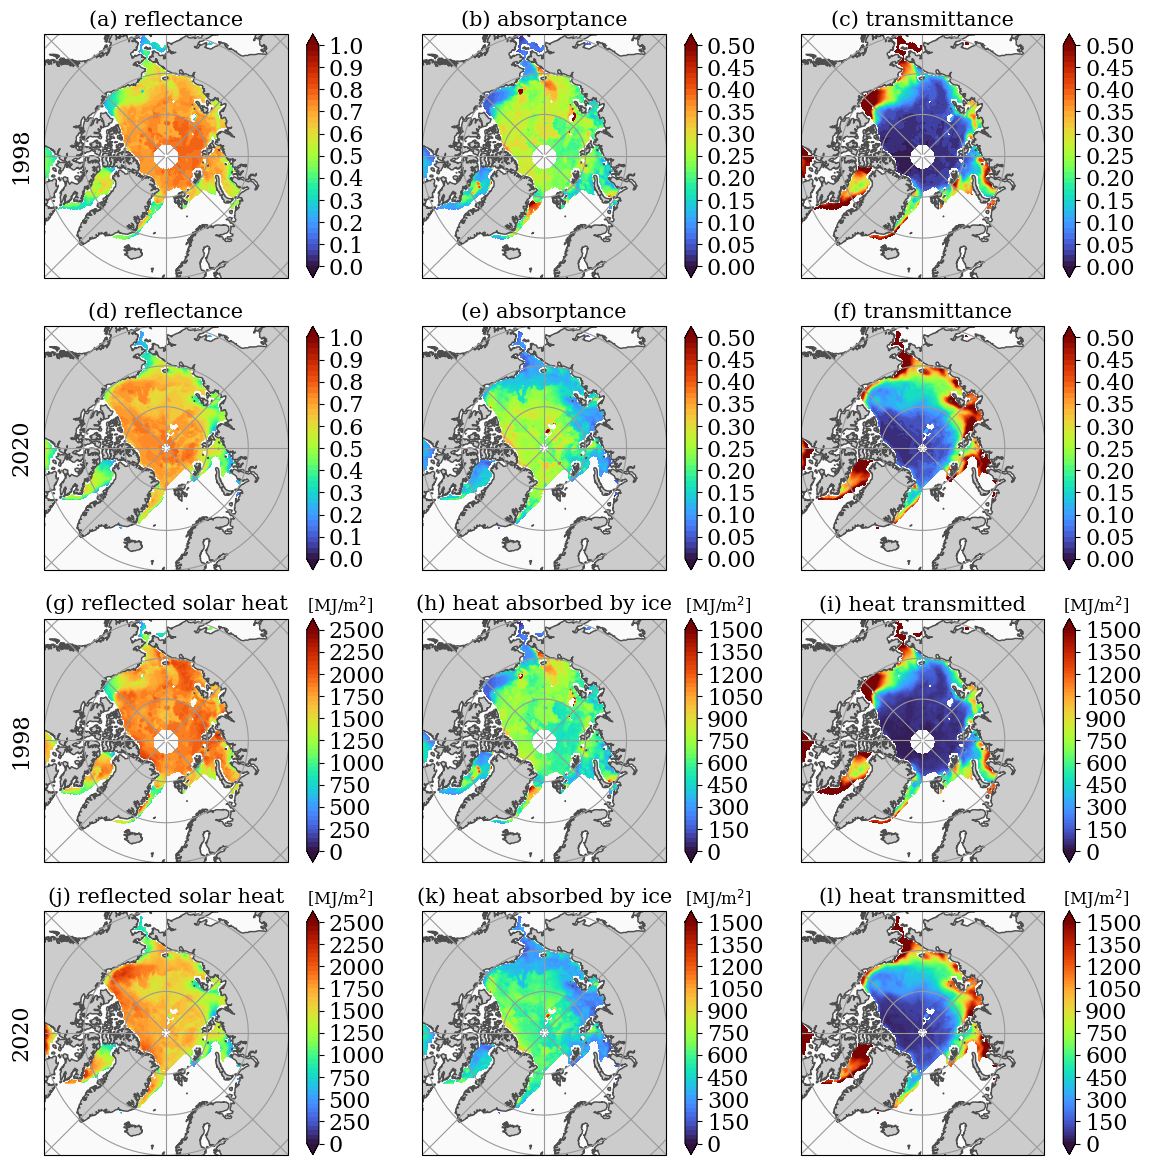

In [ ]:
fig, axs,chdls = plot_Figure1([1998,2020],dsyearly,c3r4=True,figsize=(12,12),vmax_thr=1500,vmax_rthr=.5)
fig.tight_layout()
fig.subplots_adjust(wspace=0,top=.95,hspace=0.2)
for irow in range(4):
    ax = axs[irow][0]
    tyr = [1998,2020][irow%2]
    ax.text(-0.05, 0.5, f'{tyr}', va='center', ha='right',
        rotation=90, fontsize=ftsz, transform=ax.transAxes)
picfn = picroot/f'Figure1_maybe_4x3_cblarge.{picfmt}'
#fig.savefig(picfn,format=picfmt,dpi=picdpi,bbox_inches='tight')

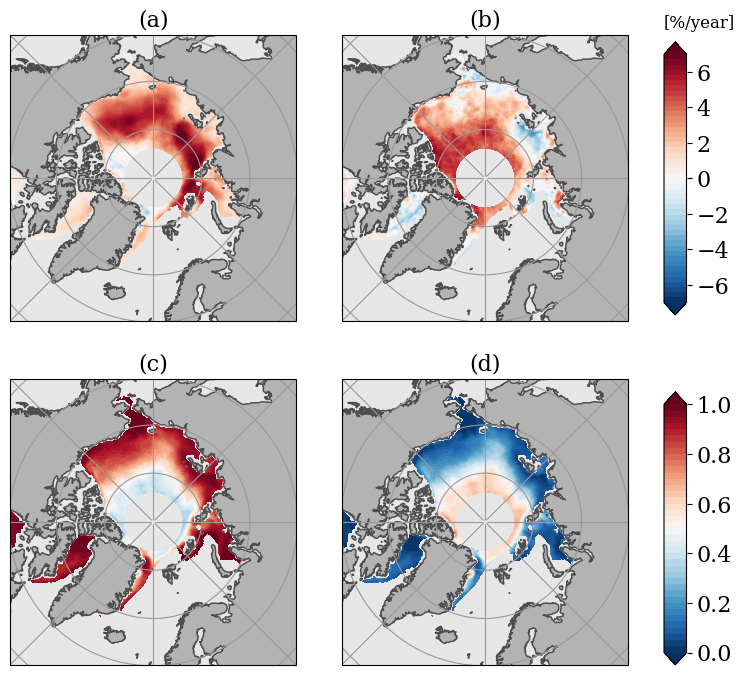

In [ ]:
yr00 = 1984
LATN = 84
LATS = 60
vrfl = 40 
vabs = 40 
vthr = 40
vrfl = 30 
vabs = 15 
vthr = 40
NYR_MISS = 10
FDR = True
FDR = 0.05
in_range = (dsyearly.lat>LATS)&(dsyearly.lat<LATN)
dattrend = ds_slope.where(in_range)
datpval = ds_pval.where(in_range)

mdat = dsyearly.mean(dim='time').where(in_range)

MJm2yr = '[MJ /(m$^{2}$ yr)]'
fig, axs = plt.subplots(2,2, figsize=(7.5,7),subplot_kw=dict(projection=boprj))
fig.tight_layout()   
fig.subplots_adjust(hspace=.2,top=.95,bottom=.05,wspace=.01,right=.9)

cb_scale = .85



ax = axs[0][0]
vn = 'oTransmittance'
fig, ax, chdl, cb = plot_trend(dattrend[vn]/mdat['oTransmittance'],
                         mask = dsmask['iTransmittance']<NYR_MISS,
                         fig=fig, ax=ax,vscale=100, cb_scale=cb_scale,add_cb=False,
                     ttl=f'(a)',cb_ttl='[%/year]',add_cb_ttl=True, cmap='RdBu_r',
                     lvl=np.linspace(-7,7,49),cb_ticks=np.linspace(-6,6,7))

ax = axs[0][1]
vn = 'iTransmittance'
fig, ax, chdl, cb = plot_trend(dattrend[vn]/mdat['iTransmittance'],
                         mask = dsmask[vn]<NYR_MISS,
                         fig=fig, ax=ax,vscale=100,cb_scale=cb_scale,add_cb=False,
                     ttl=f'(b)',cb_ttl='[%/year]',add_cb_ttl=True,cmap='RdBu_r',
                     lvl=np.linspace(-7,7,49),cb_ticks=np.linspace(-6,6,7))

cbax0 = fig.add_axes([0.92,.55,.03,.39])
cb0 = fig.colorbar(chdl,cax=cbax0,shrink=2,aspect=45)
cb0.ax.set_title('[%/year]',pad=10,loc='left')
cb0.ax.set_yticks(np.linspace(-6,6,7))


ax = axs[1][0]
vn = 'oTransmittance'
fig, ax, chdl, cb = plot_trend(mdat[vn]/mdat['Transmittance'],
                         mask = dsmask['iTransmittance']<NYR_MISS,
                         fig=fig, ax=ax,vscale=1, cb_scale=cb_scale,
                     ttl=f'(c)',cb_ttl='',add_cb_ttl=True,add_cb=False,
                     lvl=np.linspace(0,1,41),cb_ticks=np.linspace(0,1,11))

ax = axs[1][1]
vn = 'iTransmittance'
fig, ax, chdl, cb = plot_trend(mdat[vn]/mdat['Transmittance'],
                         mask = dsmask['iTransmittance']<NYR_MISS,
                         fig=fig, ax=ax,vscale=1,cb_scale=cb_scale,add_cb=False,
                     ttl=f'(d)',cb_ttl='',add_cb_ttl=True,
                     lvl=np.linspace(0,1,41),cb_ticks=np.linspace(0,1,11))

cbax0 = fig.add_axes([0.92,.05,.03,.39])
cb0 = fig.colorbar(chdl,cax=cbax0,shrink=2,aspect=45)
cb0.ax.set_yticks(np.linspace(0,1,6))

picfn = picroot/f'Fig3_transmittance_partition.{picfmt}'
fig.savefig(picfn,format=picfmt,dpi=picdpi,bbox_inches='tight')